In [11]:
%matplotlib inline
## path 바꾸기 -> 한번만 실행
import os
import matplotlib.pyplot as plt
import numpy as np
#from darkflow.net.build import TFNet
import cv2
import pytesseract


# print (os.getcwd()) #현재 디렉토리
# darkflow_path = os.path.join(os.getcwd(), 'darkflow')
# #디렉토리를 darkflow 안으로 바꿔줌
# os.chdir(darkflow_path)
# print (os.getcwd())

tables_path = 'C:/python_ML/data/test_data/ocr_tesseract/final'
table_img_list = []
for file in os.listdir(tables_path):
    file_path = f'{tables_path}/{file}'
    img = cv2.imread(file_path)
    table_img_list.append(img)

pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'

lang = 'kor+eng'
SIZE_LIST = ['팔','길이', '둘레', '밑단', '소매', '가슴', '어깨', '기장', '추천몸무게', 'kg']
LABEL_LIST = ['XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL']
SCORE_LIST = ['0','1','2','3','4','5','6','7','8','9']

print(len(file_path))


66


In [12]:

print(len(table_img_list))

811


In [13]:

# 컨투어 정보를 갖고 있는 class
class contour_info:
    def __init__(self, img, top_y, btn_y, left_x, right_x):
        self.img = img
        self.top_y = top_y
        self.btn_y = btn_y
        self.left_x = left_x
        self.right_x = right_x
    
    def m_point(self):
        point_y = int((self.btn_y + self.top_y)/2)
        point_x = int((self.right_x + self.left_x)/2)
        return point_y, point_x
    

# 행 정보를 갖고 있는 class
class row_info:
    def __init__(self,idx, rect):
        # 행을 분리하는 idx
        self.idx = idx
        # 행을 구성하는 하나의 컨투어에 대한 정보
        self.rect = rect


# 텍스트를 더 명확하게 뽑기위한 전처리
def preprocessing_img(original_img):
    blur = cv2.blur(original_img, (5,5))
    canny_img = cv2.Canny(blur, 10,10)

    kernel = np.ones((10,10), np.uint8)
    morph_gray = cv2.morphologyEx(canny_img, cv2.MORPH_CLOSE, kernel)
    return morph_gray


# 박스가 쳐진 오리지널이미지, 좌표 값을 포함하는 컨투어 리스트 반환
def black_find_contour(original_img):
    copy_img = original_img.copy()
    gray = cv2.cvtColor(copy_img, cv2.COLOR_BGR2GRAY)
    input_img = preprocessing_img(gray)
    
    contours, _ = cv2.findContours(input_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    add_length = 13
    
    rect_list = []
    for i in range(0,len(contours)):
        cnt = contours[i]
        x,y,w,h = cv2.boundingRect(cnt)
        if w < original_img.shape[1]/2 and h < original_img.shape[0]/4:
            top_y = max(0, y-add_length)
            btn_y = min(original_img.shape[0], y+h+add_length)
            left_x = max(0, x-add_length)
            right_x = min(original_img.shape[1], x+w+add_length)
#             cnt_img = cv2.rectangle(copy_img,(left_x,top_y),(right_x,btn_y),(0,0,255),2)
            rect_img = original_img[top_y:btn_y, left_x:right_x]
            rect_list.append(contour_info(rect_img, top_y, btn_y, left_x,right_x))
    return  rect_list

# 동수센세의 검은 이미지로 컨투어 
def white_find_contour(original_img):
    img = original_img
    copy_img = original_img.copy()
    img_third_first=0
    img_third_second=0
    img_third_third=0
    # (0.3 * R) + (0.59 * G) + (0.11 * B)
    # BGR로 들어옴
    for img_first in range(0,img.shape[0]):
        for img_second in range(0,img.shape[1]):
            for img_third in range(0,img.shape[2]):
                if img_third==0:
                    img_third_first=img[img_first][img_second][img_third]*0.11
                elif img_third==1:
                    img_third_second=img[img_first][img_second][img_third]*0.59
                else :
                    img_third_third=img[img_first][img_second][img_third]*0.3

            for img_third in range(0,img.shape[2]):
                img[img_first][img_second][img_third] = int(img_third_first) + int(img_third_second) +int(img_third_third)


    lower_blue=np.array([0, 0, 0])
    upper_blue=np.array([150, 150, 150])

    mask01 = cv2.inRange(img, lower_blue, upper_blue)
    for mask01_first in range (0,len(mask01)):
        for mask01_second in range (0,len(mask01[0])):
            if mask01[mask01_first][mask01_second]==0:
                mask01[mask01_first][mask01_second]=255
            elif mask01[mask01_first][mask01_second]==255:
                mask01[mask01_first][mask01_second]=0
    
    kernel = np.ones((2, 15), np.uint8)
    result = cv2.morphologyEx(mask01, cv2.MORPH_CLOSE, kernel)
    
    contours, _ = cv2.findContours(result,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    add_length = 13

    rect_list = []
    for i in range(0,len(contours)):
        cnt = contours[i]
        x,y,w,h = cv2.boundingRect(cnt)
        if w < original_img.shape[1]/2 and h < original_img.shape[0]/4:
            top_y = max(0, y-add_length)
            btn_y = min(original_img.shape[0], y+h+add_length)
            left_x = max(0, x-add_length)
            right_x = min(original_img.shape[1], x+w+add_length)
#             cnt_img = cv2.rectangle(copy_img,(left_x,top_y),(right_x,btn_y),(0,0,255),2)
            rect_img = original_img[top_y:btn_y, left_x:right_x]
            rect_list.append(contour_info(rect_img, top_y, btn_y, left_x,right_x))
    return rect_list


# 각 행정보를 줌
def split_row(rect_list):
    idx = 0
    start_point = rect_list[0].m_point()[0]
    row_list = []
    rect_list.reverse()
    for rect in rect_list:
        #print(f'start_point : {start_point}')
        # y 좌표가 위아래로 5를 넘지 않게되면 같은 행으로 취급
        if rect.m_point()[0] < start_point+3 and start_point-3 < rect.m_point()[0]:
            #print(f'rect_point : {rect.m_point()[0]}')
            row_list.append(row_info(idx, rect))
        else:
            start_point = rect.m_point()[0]
            idx += 1
            row_list.append(row_info(idx, rect))
    return row_list


# 리스트로 각 행들을 분리
def category_row(row_list):
    rows_list = []
    # 각 행의 idx값으로
    for idx in range(1, row_list[-1].idx+1):
        category_list = []
        for row in row_list:
            if idx == row.idx:
                category_list.append(row)    
        category_list.sort(key=lambda x: x.rect.left_x)
        rows_list.append(category_list)
    return rows_list


# 글자 영역 한글 인식
def text_recognition(rows_list):
    rows_text = []
    for rows in rows_list:
        row_text = []
        for row in rows:
            #text = pytesseract.image_to_string(row.rect.img, lang=lang)
            text = ds_preprocessing(row.rect.img)
            row_text.append(text)
        if len(row_text) > 4:
            rows_text.append(row_text)
    return rows_text



# 글씨가 흰색이면 바탕을 하얗게 글씨를 검은색으로
def ds_preprocessing(img):
    img_b = int(img[7][5][0])
    img_g = int(img[7][5][1])
    img_r = int(img[7][5][2])
    
    color_select = 10
    
    img_mean = (img_b+img_g+img_r)/3
    
    text = ''
    if img_mean >= 235:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary_img = cv2.threshold(gray_img, 125, 255, cv2.THRESH_BINARY)
        text = pytesseract.image_to_string(binary_img, lang=lang)
        return text
        # 그냥 tesseract 돌리고
    
    else:
        img_b_div = img_b/2
        img_g_div = img_g/2
        img_r_div = img_r/2
         
        img_b_lower=img_b-img_b_div-color_select
        img_g_lower=img_g-img_g_div-color_select
        img_r_lower=img_r-img_r_div-color_select
        
        img_b_upper=img_b+img_b_div+color_select
        img_g_upper=img_g+img_g_div+color_select
        img_r_upper=img_r+img_r_div+color_select
        
        
        lower_color=np.array([img_b_lower,img_g_lower,img_r_lower])
        upper_color=np.array([img_b_upper,img_g_upper,img_r_upper])

        img_mask = cv2.inRange(img, lower_color, upper_color)
        text = pytesseract.image_to_string(img_mask, lang=lang)

        return text

# 행 시작하는 부분, 팔 값 리스트, 어깨 값 리스트
def find_column(text_list):
    column_list = []
    for texts in text_list:
        count = 0
        for text in texts:
            for sch in SIZE_LIST:
                if sch in text:
                    count += 1
        column_list.append(count)
    if len(column_list) == 0:
        return False, False, False
    
    column_idx = np.argmax(column_list)
    arm_col = -1
    shoulder_col = -1
    for idx, text in enumerate(text_list[column_idx]):
        if '팔' in text or '소매' in text:
            arm_col = idx
            print(f'arm : {arm_col}')
            continue
        if '어깨' in text or '어째' in text:
            shoulder_col = idx
            print(f'shoulder_col : {shoulder_col}')
            continue
    
    arm_list = []
    shoulder_list = []
    for columns in text_list[column_idx+1:]:
        if arm_col != -1:
            arm_value = columns[arm_col]
            arm_list.append(arm_value)
        if shoulder_col != -1:
            sholder_value = columns[shoulder_col]
            shoulder_list.append(sholder_value)
    return column_idx, arm_list, shoulder_list


# 테이블이 얼마나 비어있는지 수치 비교 낮을수록 더 잘 뽑은거
def count_hist(text_list):
    non = 0
    score = 0
    for rows in text_list:
        for text in rows:
            if len(text) == 0:
                non += 1
            else:
                score += 1
    return round((non / (score + non)) * 100)


class size_table_info:
    def __init__(self, size_bool, arm_size, sh_size):
        self.size_bool = size_bool
        self.arm_size = arm_size
        self.sh_size = sh_size
        

def text_check(black_text, white_text):
    
    # 0 0
    if len(black_text) == 0 and len(white_text) == 0:
        return size_table_info(False, [], [])
    # 1 0 
    # 0 1
    # 1 1
    
    bk_col, bk_arm, bk_sh = find_column(black_text)
    wh_col, wh_arm, wh_sh = find_column(white_text)
    
    if bk_col == True and wh_col == True:
        if count_hist(black_text[bk_col+1:]) < count_hist(white_text[wh_col+1:]):
            return size_table_info(True, bk_arm, bk_sh)
        else:
            return size_table_info(True, wh_arm, wh_sh)
    elif bk_col == False and wh_col == True:
        return size_table_info(True, wh_arm, wh_sh)
    elif bk_col == True and wh_col == False:
        return size_table_info(True, bk_arm, bk_sh)
    else:
        return size_table_info(False, wh_arm, wh_sh)


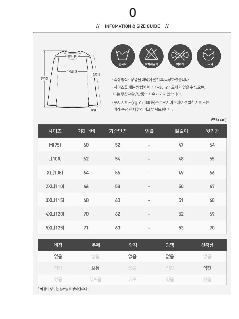

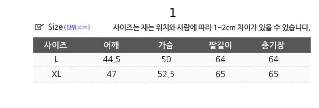

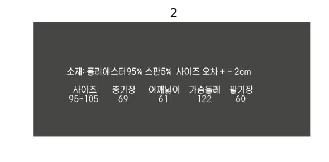

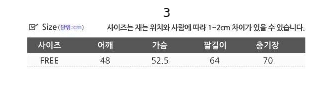

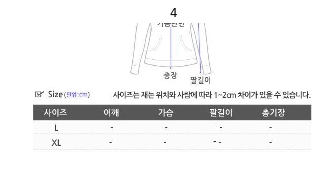

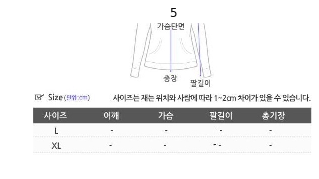

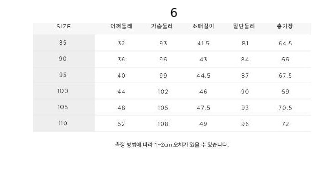

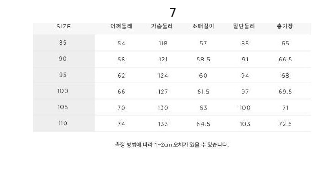

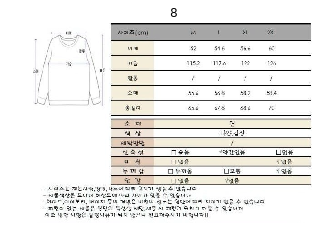

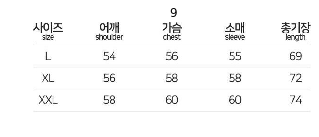

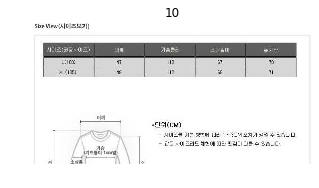

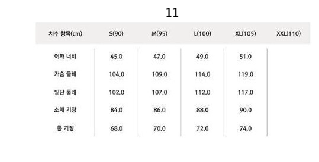

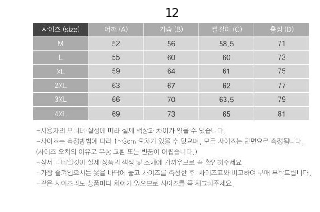

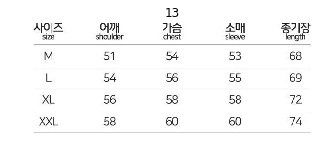

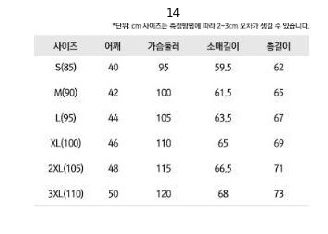

In [14]:
for idx, img in enumerate(table_img_list[:15]):
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    plt.title(f'{idx}')
    axes.imshow(img)
    axes.axis('off')

In [15]:
size_table = []

for table in table_img_list[:10]:
    try:
        # 영역치고
        black_rect = black_find_contour(table)
        if len(black_rect) == 0:
            white_rect = white_find_contour(table)
            white_row = split_row(white_rect)
            white_rows_list = category_row(white_row)
            white_text = text_recognition(white_rows_list)
        else:
        # 행으로 분리하고
            black_row = split_row(black_rect)
            # 분리된 행 카테고리화 하고
            black_rows_list = category_row(black_row)

            # 텍스트 인식하고
            black_text = text_recognition(black_rows_list)

            # 체크 하고
            text = text_check(black_text, white_text)
            size_table.append(text)
    except Exception as e:
        print(f'error : {e}')
        continue

error : name 'white_text' is not defined
error : name 'white_text' is not defined
error : name 'white_text' is not defined
error : name 'white_text' is not defined
error : name 'white_text' is not defined
error : name 'white_text' is not defined
error : name 'white_text' is not defined
error : name 'white_text' is not defined
error : name 'white_text' is not defined
error : name 'white_text' is not defined


In [ ]:
size_table = []
for table in table_img_list[:10]:
    try:
        # 영역치고
        black_rect = black_find_contour(table)
        if len(black_rect) == 0:
            white_rect = white_find_contour(table)
            white_row = split_row(white_rect)
            white_rows_list = category_row(white_row)
            white_text = text_recognition(white_rows_list)
        else:
        # 행으로 분리하고
        black_row = split_row(black_rect)
        # 분리된 행 카테고리화 하고
        black_rows_list = category_row(black_row)
        
        # 텍스트 인식하고
        black_text = text_recognition(black_rows_list)
        
        # 체크 하고
        text = text_check(black_text, white_text)
        size_table.append(text)
    except Exception as e:
        print(f'error : {e}')
        continue

In [83]:
for size in size_table:
    print(f'성공여부 : {size.size_bool} 팔 길이 : {size.arm_size} 어깨 넓이 : {size.sh_size}')

성공여부 : True 팔 길이 : ['47', '48', '49', '50', '51', '52', '53', ''] 어깨 넓이 : ['60', '62', '64', '66', '68', '70', '71', '']
성공여부 : False 팔 길이 : [] 어깨 넓이 : []
성공여부 : False 팔 길이 : [] 어깨 넓이 : []
성공여부 : False 팔 길이 : [] 어깨 넓이 : []
성공여부 : False 팔 길이 : [] 어깨 넓이 : []
성공여부 : False 팔 길이 : [] 어깨 넓이 : []
성공여부 : False 팔 길이 : [] 어깨 넓이 : []
성공여부 : False 팔 길이 : [] 어깨 넓이 : []
성공여부 : False 팔 길이 : [] 어깨 넓이 : []
